## Feature Selection

> - Author: Shenghui
> - Date: 2023/05

In feature engineering, we generated over 100+ new features to depict each entity, i.e. horse, jockey, and trainer. To improve the downstream model's interpretability and to reduce their complxity, filtering uninformative numeric features is indispensable. 

In this notebook, the main technique is cross validation based on Logistic Regression with L1-penalty. 

Main steps involved will be:
1. Unifing naming rules on columns
2. Data preparation for LR CV
3. Performance analysis, and feature selection
4. Appendix (Hypothesis Test: Z-test, LR-test; BIC trial)

## 1 Read Data, and Unifing naming rules

In [30]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./horse/data/feature.csv')
df = df.drop('jockey_racenum_y', axis=1)

df.head()

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,...,trainer_showups,trainer_top4_h,trainer_top4_rate_h,trainer_top4_last5,trainer_top4_y,trainer_top4_rate_y,trainer_top4_m,trainer_top4_rate_m,trainer_top4_d,trainer_top4_rate_d
0,2015/04/22_1,2015/4/22,2,1000,好地至快地,草地,575000,120,1186,7.3,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
1,2015/04/22_1,2015/4/22,3,1000,好地至快地,草地,575000,132,1022,6.1,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
2,2015/04/22_1,2015/4/22,5,1000,好地至快地,草地,575000,121,1085,48.0,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
3,2015/04/22_1,2015/4/22,7,1000,好地至快地,草地,575000,127,1211,7.8,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
4,2015/04/22_1,2015/4/22,1,1000,好地至快地,草地,575000,124,1088,14.0,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0


In [1]:
""" [Naming Rule] """
# 命名规则： {entity}_{metric}_{granularity}
# 例如：马过去一年的夺冠率 
# - entity: horse
# - metric: champ
# - granularity: y
#   => horse_champ_y

' [Naming Rule] '

In [31]:

colname_replace_dict = {
    'jockey_x':'jockey'
    , 'trainer_x':'trainer'
    ######## horse ########
    # race
    , 'horse_top-4':'horse_is_top4'
    # hist
    , 'horse_hist_places':'horse_place_h'
    , 'horse_hist_champs':'horse_champs_h'
    , 'horse_hist_top4s':'horse_top4_h'
    , 'horse_hist_best_perform':'horse_bestperform_h'
    , 'horse_hist_place_rate':'horse_place_rate_h'
    , 'horse_hist_champ_rate':'horse_champ_rate_h'
    , 'horse_hist_top4_rate':'horse_top4_rate_h'
    # last 5
    , 'champ_last5':'horse_champ_last5'
    , 'place_last5':'horse_place_last5'
    , 'top4_last5':'horse_top4_last5'
    # year
    , 'num_games_year':'horse_racenum_y'
        ##? num
    , 'horse_year_champ_rate':'horse_champ_rate_y'
    , 'horse_year_place_rate':'horse_place_rate_y'
    , 'horse_year_top4_rate':'horse_top4_rate_y'
    # month
    , 'num_games_month':'num_racenum_m'
    , 'horse_month_champ':'horse_champ_m'
    , 'horse_month_place':'horse_place_m'
    , 'horse_month_top4':'horse_top4_m'
    , 'horse_month_champ_rate':'horse_champ_rate_m'
    , 'horse_month_place_rate':'horse_place_rate_m'
    , 'horse_month_top4_rate':'horse_top4_rate_m'
    ################ jockey ################
    # race
    , 'jockey_top-4':'jockey_is_top4'
    # hist
    , 'jockey_hist_champs':'jockey_champ_h'
    , 'jockey_hist_places':'jockey_place_h'
    , 'jockey_hist_top4s':'jockey_top4_h'
    , 'jockey_hist_best_perform':'jockey_best_perform_h'
    , 'jockey_hist_champ_rate':'jockey_champ_rate_h'
    , 'jockey_hist_place_rate':'jockey_place_rate_h'
    , 'jockey_hist_top4_rate':'jockey_top4_rate_h'
    # last5
    , 'Jockey_champ_last5':'jockey_champ_last5'
    , 'Jockey_place_last5':'jockey_place_last5'
    , 'Jockey_top4_last5':'jockey_top4_last5'
    # year
    , 'jockey_year_num':'jockey_racenum_y'
    , 'jockey_year_champ':'jockey_champ_y'
    , 'jockey_year_place':'jockey_place_y'
    , 'jockey_year_top4':'jockey_top4_y'
    , 'jockey_year_champ_rate':'jockey_champ_rate_y'
    , 'jockey_year_place_rate':'jockey_place_rate_y'
    , 'jockey_year_top4_rate':'jockey_top4_rate_y'
    # month
    , 'jockey_num_month':'jockey_racenum_m'
    , 'jockey_month_champ':'jockey_champ_m'
    , 'jockey_month_place':'jockey_place_m'
    , 'jockey_month_top4':'jockey_top4_m'
    , 'jockey_month_champ_rate':'jockey_champ_rate_m'
    , 'jockey_month_place_rate':'jockey_place_rate_m'
    , 'jockey_month_top4_rate':'jockey_top4_rate_m'
    # day
    , 'jockey_num_day':'jockey_racenum_d'
    , 'jockey_day_champ':'jockey_champ_d'
    , 'jockey_day_place':'jockey_place_d'
    , 'jockey_day_top4':'jockey_top4_d'
    , 'jockey_day_champ_rate':'jockey_champ_rate_d'
    , 'jockey_day_place_rate':'jockey_place_rate_d'
    , 'jockey_day_top4_rate':'jockey_top4_rate_d'
    ################# trainer #################
    # race
    , 'trainer_top-4':'trainer_is_top4'
    # hist
    , 'trainer_hist_places':'trainer_place_h'
    , 'trainer_hist_champs':'trainer_champ_h'
    , 'trainer_hist_top4s':'trainer_top4_h'
    , 'trainer_hist_best_perform':'trainer_best_perform_h'
    , 'trainer_hist_champ_rate':'trainer_champ_rate_h'
    , 'trainer_hist_place_rate':'trainer_place_rate_h'
    , 'trainer_hist_top4_rate':'trainer_top4_rate_h' 
    # year
    , 'trainer_year_num':'trainer_racenum_y'
    , 'trainer_year_champ':'trainer_champ_y'
    , 'trainer_year_place':'trainer_place_y'
    , 'trainer_year_top4':'trainer_top4_y'
    , 'trainer_year_champ_rate':'trainer_champ_rate_y'
    , 'trainer_year_place_rate':'trainer_place_rate_y'
    , 'trainer_year_top4_rate':'trainer_top4_rate_y'
    # month
    , 'trainer_num_month':'trainer_racenum_m'
    , 'trainer_month_champ':'trainer_champ_m'
    , 'trainer_month_place':'trainer_place_m'
    , 'trainer_month_top4':'trainer_top4_m'
    , 'trainer_month_champ_rate':'trainer_champ_rate_m'
    , 'trainer_month_place_rate':'trainer_place_rate_m'
    , 'trainer_month_top4_rate':'trainer_top4_rate_m'
    # day
    , 'trainer_num_day':'trainer_racenum_d'
    , 'trainer_day_champ':'trainer_champ_d'
    , 'trainer_day_place':'trainer_place_d'
    , 'trainer_day_top4':'trainer_top4_d'
    , 'trainer_day_champ_rate':'trainer_champ_rate_d'
    , 'trainer_day_place_rate':'trainer_place_rate_d'
    , 'trainer_day_top4_rate':'trainer_top4_rate_d'
    ################## elo #################
    , 'score_jockey':'jockey_elo'
    , 'score_horse':'horse_elo'
    , 'score_trainer':'trainer_elo'
    , 'score_jockey_c':'jockey_elo_course'
    , 'score_horse_c':'horse_elo_course'
    , 'score_trainer_c':'trainer_elo_course'

}

col_modif = []
for col in df.columns.tolist():
    if col in colname_replace_dict:
        col_modif.append(colname_replace_dict[col])
    else:
        col_modif.append(col)

df.columns = col_modif
# sort col
cut_point = col_modif.index('finish_time')
orig_feats = col_modif[:cut_point+1]
new_feats = sorted(col_modif[cut_point+1:], key=lambda x: (x.split('_')[0], x.split('_')[1]))
df = df[orig_feats+new_feats]

df['is_champ'] = df['pla'].apply(lambda x: 1 if x==1 else 0)

print(df.shape)
# df.head()

(54436, 129)


In [32]:
df[(df['race_date']=='2015/4/22')&(df['jockey']=='何澤堯')]

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,...,trainer_showups,trainer_top4_h,trainer_top4_rate_h,trainer_top4_last5,trainer_top4_y,trainer_top4_rate_y,trainer_top4_m,trainer_top4_rate_m,trainer_top4_d,trainer_top4_rate_d
12,2015/04/22_2,2015/4/22,8,1200,好地至快地,草地,760000,120,1124,8.3,...,0,0,0.000000,0.000000,0,0.0,0,0.0,0,0.000000
48,2015/04/22_5,2015/4/22,5,1650,好地至快地,草地,760000,128,1156,13.0,...,4,2,0.500000,0.500000,0,0.0,0,0.0,2,0.500000
82,2015/04/22_7,2015/4/22,9,1650,好地至快地,草地,1060000,124,1109,27.0,...,5,3,0.600000,0.600000,0,0.0,0,0.0,3,0.600000
89,2015/04/22_8,2015/4/22,2,1200,好地至快地,草地,1500000,121,1048,59.0,...,3,1,0.333333,0.333333,0,0.0,0,0.0,1,0.333333


In [12]:
df[(df['race_key']=='2015/04/22_7')&(df['pla']==1)].squeeze().to_frame().to_csv('1line.csv')

In [33]:
###################### STEP 1: Save data  ######################
src = './horse/data/perform_full_feature.csv'
df.to_csv(src, index=False)
df = pd.read_csv(src, )

# col_wo_elo = [col for col in df.columns if 'elo' not in col]
# df = df[col_wo_elo]

df.head()

,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,...,trainer_showups,trainer_top4_h,trainer_top4_rate_h,trainer_top4_last5,trainer_top4_y,trainer_top4_rate_y,trainer_top4_m,trainer_top4_rate_m,trainer_top4_d,trainer_top4_rate_d
0,2015/04/22_1,2015/4/22,2,1000,好地至快地,草地,575000,120,1186,7.3,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
1,2015/04/22_1,2015/4/22,3,1000,好地至快地,草地,575000,132,1022,6.1,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
2,2015/04/22_1,2015/4/22,5,1000,好地至快地,草地,575000,121,1085,48.0,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
3,2015/04/22_1,2015/4/22,7,1000,好地至快地,草地,575000,127,1211,7.8,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0
4,2015/04/22_1,2015/4/22,1,1000,好地至快地,草地,575000,124,1088,14.0,...,0,0,0.0,0.0,0,0.0,0,0.0,0,0.0


## 2 Data Preparation 

In [2]:
################# STEP 2: Prep data for LASSO  #################
from horse.data.load_data import DataSet
src = './horse/data/perform_full_feature.csv'

dataset = DataSet(src, scaling=False, do_categorization=False, do_dummy=False, use_best_feats=False)
perc = [0.8, 0.1, 0.1]
train, val, test = dataset.train_val_test_split(perc)
# train = train[col_wo_elo]
# val = val[col_wo_elo]
# test = test[col_wo_elo]

print(train.shape, val.shape, test.shape)

train.head()

(43157, 130) (5558, 130) (5721, 130)


,race_key,race_date,dr,distance,field_going,course_type,race_money,act_wt,declare_horse_wt,win_odds,...,trainer_top4_h,trainer_top4_rate_h,trainer_top4_last5,trainer_top4_y,trainer_top4_rate_y,trainer_top4_m,trainer_top4_rate_m,trainer_top4_d,trainer_top4_rate_d,speed
0,2015/04/22_1,2015/4/22,2,1000,好地至快地,1,575000,120,1186,7.3,...,0,0.0,0.0,0,0.0,0,0.0,0,0.0,17.430713
1,2015/04/22_1,2015/4/22,3,1000,好地至快地,1,575000,132,1022,6.1,...,0,0.0,0.0,0,0.0,0,0.0,0,0.0,17.382235
2,2015/04/22_1,2015/4/22,5,1000,好地至快地,1,575000,121,1085,48.0,...,0,0.0,0.0,0,0.0,0,0.0,0,0.0,17.307027
3,2015/04/22_1,2015/4/22,7,1000,好地至快地,1,575000,127,1211,7.8,...,0,0.0,0.0,0,0.0,0,0.0,0,0.0,17.295054
4,2015/04/22_1,2015/4/22,1,1000,好地至快地,1,575000,124,1088,14.0,...,0,0.0,0.0,0,0.0,0,0.0,0,0.0,17.274141


In [46]:
# 由于id过多，暂时都drop，用过去的表现来代表id
y_cols = ['is_champ', 'pla', 'finish_time', 'speed']
dummies = ['race_key', 'race_date', 'dr', 'field_going', 'trainer', 'horse', 'jockey']
train_dedum = train.drop(dummies, axis='columns')

# 提取其他可能包含结果的字段
import re
target_like_cols = ['is_champ', 'is_place', 'is_top4']
regexp = re.compile('|'.join(target_like_cols))
for col in train_dedum.columns:
    if regexp.search(col):
        y_cols.append(col)

# 获取x列
get_x_cols = lambda x: [col for col in x if (col not in y_cols)]
drop_odds = lambda x: [col for col in x if (col!='win_odds')]
        
x_cols = get_x_cols(train_dedum.columns)
x_cols = drop_odds(x_cols)
y_col = ['is_champ']

X, y = train_dedum[x_cols], train_dedum[y_col]

print(f'Count of dummy variable fields: {len(dummies)}')
print(f'Count of target-like fields: {len(y_cols)}')
print(f'Column count from {train.shape[1]} to {X.shape[1]}')

X.shape, y.shape

Count of dummy variable fields: 7
Count of target-like fields: 14
Column count from 130 to 109


((43157, 109), (43157, 1))

## 3 Logistic Regression Cross Validation with L1-Penalty

### 3.1 Import necessary packages

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC, LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline


### 3.2 Fitting LRCV, eval with acc

[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


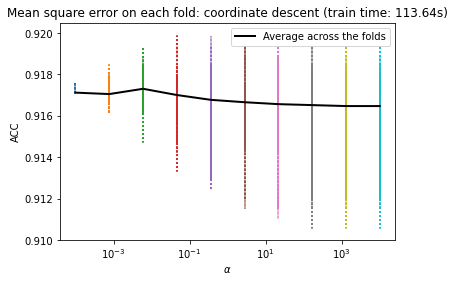

In [25]:
from sklearn.linear_model import LogisticRegressionCV
import time 
import matplotlib.pyplot as plt

n_cv = 20
start_time = time.time()
model = make_pipeline(StandardScaler(), LogisticRegressionCV(cv=n_cv)).fit(X, y)
fit_time = time.time() - start_time

logistic = model[-1]

print(logistic.Cs_)

plt.semilogx([logistic.Cs_ for _ in range(n_cv)], logistic.scores_[1], linestyle=":")
plt.plot(
    logistic.Cs_,
    logistic.scores_[1].mean(axis=0),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

ymin, ymax = 0.910, 0.9205
plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("ACC")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)

### 3.2 Eval with Average Precision

In [33]:
from horse.process import comupte_champ, racing_champ

def AveragePrecision(input, target):
    merge_df = input.merge(target, on='race_key', how='left')
    
    return (merge_df.iloc[:, 1]==merge_df.iloc[:, 2]).sum()/merge_df.shape[0]

# 由于id过多，暂时都drop，用过去的表现来代表id
dummies = ['race_key', 'race_date', 'dr', 'field_going', 'trainer', 'horse', 'jockey']
val_dedum = val.drop(dummies, axis='columns')
        
x_cols = get_x_cols(val_dedum.columns)
x_cols = drop_odds(x_cols)
y_col = ['is_champ']

val_X, val_y = val_dedum[x_cols], val_dedum[y_col]

rest_feat_num = []
train_APs = []
val_APs = []

# train
models = []
result_train = train[['race_key', 'dr']]
champ_true_train = racing_champ(train)
# val
result_val = val[['race_key', 'dr']]
champ_true_val = racing_champ(val)

standard_X = StandardScaler().fit_transform(X)
standard_valX = StandardScaler().fit_transform(val_X)

for c in logistic.Cs_:
    t1=time.time()
    lr = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    lr.fit(standard_X, y)
    num_of_coefs = sum(lr.coef_[0]!=0)
    
    result_train['win'] = lr.predict_proba(standard_X)[:, 1]
    champ_pred_train = result_train.groupby(['race_key']) \
                       .apply(lambda x: x[x['win']==x['win'].max()]) \
                       .reset_index(drop=True)[['race_key', 'dr']]
    
    result_val['win'] = lr.predict_proba(standard_valX)[:, 1]
    champ_pred_val = result_val.groupby(['race_key']) \
                       .apply(lambda x: x[x['win']==x['win'].max()]) \
                       .reset_index(drop=True)[['race_key', 'dr']]
    
    ap_train = AveragePrecision(champ_pred_train, champ_true_train)
    ap_val = AveragePrecision(champ_pred_val, champ_true_val)
    
    rest_feat_num.append(num_of_coefs)
    models.append(lr)
    train_APs.append(ap_train)
    val_APs.append(ap_val)
    t2=time.time()

    print(f'[{round(t2-t1, 3)}s] C: {round(c, 4)}, num_of_coefs: {num_of_coefs}, AP on train: {round(ap_train, 5)}, AP on val: {round(ap_val, 5)}')

[5.135s] C: 0.0001, num_of_coefs: 0, AP on train: 0.08277, AP on val: 0.08459
[5.064s] C: 0.0008, num_of_coefs: 2, AP on train: 0.24507, AP on val: 0.23256
[5.371s] C: 0.006, num_of_coefs: 22, AP on train: 0.25285, AP on val: 0.26483
[8.847s] C: 0.0464, num_of_coefs: 57, AP on train: 0.27486, AP on val: 0.26695
[108.882s] C: 0.3594, num_of_coefs: 94, AP on train: 0.28296, AP on val: 0.27966
[136.625s] C: 2.7826, num_of_coefs: 107, AP on train: 0.28687, AP on val: 0.27119
[133.198s] C: 21.5443, num_of_coefs: 108, AP on train: 0.28743, AP on val: 0.26907
[150.37s] C: 166.8101, num_of_coefs: 108, AP on train: 0.28715, AP on val: 0.27331
[133.35s] C: 1291.5497, num_of_coefs: 108, AP on train: 0.28659, AP on val: 0.27119
[134.015s] C: 10000.0, num_of_coefs: 109, AP on train: 0.28659, AP on val: 0.27331


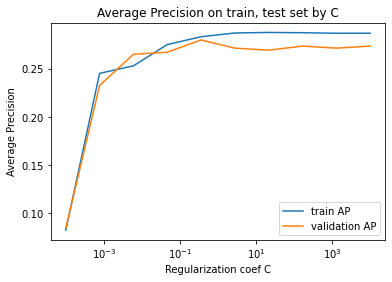

In [34]:
plt.semilogx(logistic.Cs_, train_APs, label='train AP')
plt.semilogx(logistic.Cs_, val_APs, label='validation AP')
plt.xlabel("Regularization coef C")
plt.ylabel("Average Precision")
plt.legend()
plt.title(
    f"Average Precision on train, test set by C"
)
plt.legend()
plt.show()

### 3.3 Analysis

L1 penalty=1/0.0008, when the number of rest features=22 is suitable, for the reliability of prediction, decent validation AP, fast training time, and light number of features:
1. **reliability of prediction**: accuracy culminates when L1 penalty=1/0.0008, and the standard deviation across each fold is relatively low, indicating reliable, and stable predictions given the 22 features.
2. **decent validation AP**: adding more features over 57 achieve better performance w.r.t. training AP, the validation AP is nearly the same as 22
3. **fast training time**: training time of high penalty coefficient would be hard to tolerate with over 100 seconds for merely logistic model, however, the one we prefer, only takes 5 secs.
4. **light number of features**: only 22/100 features is of engough high predictability, idealy matching feature selection.

### 3.4 See what's left

In [27]:
from sklearn.linear_model import LogisticRegression

alpha = logistic.Cs_[2]

lr = LogisticRegression(penalty='l1', solver='liblinear', C=alpha)
lr.fit(StandardScaler().fit_transform(X), y)

print(f'left features {sum(lr.coef_[0]!=0)}')

cols_coefs = list(zip(X.columns.tolist(), lr.coef_[0]))
cols_coefs = [item for item in cols_coefs if item[1]!=0]
ix = list(range(len(cols_coefs)))
# coefs = pd.DataFrame(cols_coefs, columns=['col', 'coef'])
# coefs.sort_values(by='coef')


import math
list(zip(ix, sorted(cols_coefs, key=lambda x: math.exp(x[1]), reverse=True)))[:22]

left features 22


[(0, ('jockey_champ_rate_y', 0.4939407945552042)),
 (1, ('horse_top4_last5', 0.13496726629880776)),
 (2, ('horse_top4_rate_y', 0.08669559306528589)),
 (3, ('jockey_top4_rate_m', 0.048408369876734726)),
 (4, ('horse_place_m', 0.04197912641988503)),
 (5, ('jockey_top4_rate_y', 0.03422368760342304)),
 (6, ('trainer_champ_rate_h', 0.034220280157686356)),
 (7, ('horse_champ_rate_h', 0.029335929279159057)),
 (8, ('jockey_champ_y', 0.0204890260232922)),
 (9, ('trainer_top4_rate_y', 0.012494189480147062)),
 (10, ('jockey_top4_m', 0.01046593794332338)),
 (11, ('trainer_champ_rate_y', 0.008541902750596722)),
 (12, ('jockey_elo', 0.008422480273707606)),
 (13, ('trainer_place_rate_h', 0.006936065898216366)),
 (14, ('trainer_top4_rate_m', 0.0026734217182710347)),
 (15, ('race_money', -0.0034832786594886753)),
 (16, ('horse_champs_h', -0.003509813576313384)),
 (17, ('horse_top4_h', -0.010010185072407352)),
 (18, ('horse_life_time_d', -0.012662840745139868)),
 (19, ('jockey_champ_last5', -0.017345036

In [39]:
pd.DataFrame({
    'C': logistic.Cs_
    , 'num':[0, 2, 22, 57, 94, 107, 108, 108, 108, 109]
    , 'train_AP': train_APs
    , 'val_AP':train_APs
    , 'time':[5.135, 5.064, 5.371, 8.847, 108.882, 136.625, 133.198, 150.37, 133.35, 134.015]
    , 'train_ACC_avg':logistic.scores_[1].mean(axis=0)
    , 'train_ACC_std':logistic.scores_[1].std(axis=0)
}).to_csv('./dim_reduce_analysis.csv', index=False)

In [29]:
best_feat = []

for f in cols_coefs:
    if f[1]!=0:
        best_feat.append(f[0])

len(best_feat), best_feat

22

## Appendix 1. Hypothesis Testing 1: Z-test on features

Fitted with statmodel, each feature's importance is ready for further tests.

It turns out that, still many features are insignificant, with low p-value. Should we drop them?

In [40]:
best_feat = [
 'race_money',
 'horse_bestperform_h',
 'horse_champ_rate_h',
 'horse_champs_h',
 'horse_life_time_d',
 'horse_place_m',
 'horse_top4_rate_y',
 'horse_top4_h',
 'horse_top4_last5',
 'jockey_champ_rate_h',
 'jockey_champ_last5',
 'jockey_champ_y',
 'jockey_champ_rate_y',
 'jockey_elo',
 'jockey_top4_rate_y',
 'jockey_top4_m',
 'jockey_top4_rate_m',
 'trainer_champ_rate_h',
 'trainer_champ_rate_y',
 'trainer_place_rate_h',
 'trainer_top4_rate_y',
 'trainer_top4_rate_m'
]

X, y = X[best_feat], y

import statsmodels.api as sm

log_reg = sm.Logit(y, StandardScaler().fit_transform(X)).fit_regularized(method='l1', alpha=alpha)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6806354497448441
            Iterations: 41
            Function evaluations: 42
            Gradient evaluations: 41


/userhome/cs2/shenghui/anaconda3/lib/python3.8/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 22 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/userhome/cs2/shenghui/anaconda3/lib/python3.8/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [57]:
columns_to_analyze = dummies+best_feat+y_cols
dataset.data[columns_to_analyze].to_csv('./reduced_data_final.csv', index=False)

In [45]:
print(X.columns.tolist())

['race_money', 'horse_bestperform_h', 'horse_champ_rate_h', 'horse_champs_h', 'horse_life_time_d', 'horse_place_m', 'horse_top4_rate_y', 'horse_top4_h', 'horse_top4_last5', 'jockey_champ_rate_h', 'jockey_champ_last5', 'jockey_champ_y', 'jockey_champ_rate_y', 'jockey_elo', 'jockey_top4_rate_y', 'jockey_top4_m', 'jockey_top4_rate_m', 'trainer_champ_rate_h', 'trainer_champ_rate_y', 'trainer_place_rate_h', 'trainer_top4_rate_y', 'trainer_top4_rate_m']


In [41]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               is_champ   No. Observations:                43157
Model:                          Logit   Df Residuals:                    43135
Method:                           MLE   Df Model:                           21
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:                  -1.380
Time:                        01:14:41   Log-Likelihood:                -29374.
converged:                       True   LL-Null:                       -12340.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0146      0.010     -1.433      0.152      -0.035       0.005
x2            -0.0273      0.012     -2.345      0.019      -0.050      -0.004
x3             0.0579      0.016      3.674      0.0

## Appendix 2. Hypothesis Testing 2: Likelihood Ratio Test against Full Model

Comparing the reduced, and the full model with Likelihood Ratio (LR) Test, we are able to know if model's predictability is significantly affected if reduce some predictors.

But the result is bit pessimestic, our nested model failed to pass the LR test. But afterall, it is suitable for lighter params, and good acc, performance as analyzed above

In [47]:
log_reg_full = sm.Logit(y, StandardScaler().fit_transform(X)).fit_regularized(method='l1', alpha=alpha)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6792161146989754
            Iterations: 381
            Function evaluations: 382
            Gradient evaluations: 381


/userhome/cs2/shenghui/anaconda3/lib/python3.8/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 83 out of 109 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/userhome/cs2/shenghui/anaconda3/lib/python3.8/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [48]:
print(log_reg_full.summary())

                           Logit Regression Results                           
Dep. Variable:               is_champ   No. Observations:                43157
Model:                          Logit   Df Residuals:                    43048
Method:                           MLE   Df Model:                          108
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:                  -1.376
Time:                        01:19:41   Log-Likelihood:                -29313.
converged:                       True   LL-Null:                       -12340.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0021      0.010     -0.204      0.838      -0.022       0.018
x2            -0.0026      0.010     -0.263      0.792      -0.022       0.017
x3            -0.0181      0.012     -1.548      0.1

In [51]:
import scipy

full_ll = log_reg_full.llf
reduced_ll = log_reg.llf

#calculate likelihood ratio Chi-Squared test statistic
LR_statistic = -2*(reduced_ll-full_ll)

print(f'LR static: {LR_statistic}')

#calculate p-value of test statistic using 2 degrees of freedom
p_val = scipy.stats.chi2.sf(LR_statistic, 2)

print(f'p-value {p_val}')


LR static: 122.68027206053375
p-value 2.29254253870389e-27


## Appendix 3. AIC, BIC for feature selection

SKLEARN does not support BIC for Logistic model, we applied with LASSO instead by relieving some of the assumptions. The result is, as we expected, worse than CV. Hence, we will only show some of the processes.

In [5]:


alphas = np.arange(1e-8,1,1e-5)

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

print(fit_time)

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X, y)
ix = list(range(len(X.columns)))
cols_coefs = list(zip(X.columns.tolist(), lr.coef_[0]))
# coefs = pd.DataFrame(cols_coefs, columns=['col', 'coef'])
# coefs.sort_values(by='coef')

import math
list(zip(ix, sorted(cols_coefs, key=lambda x: math.exp(x[1]), reverse=True)))[:10]

0.9803028106689453


[(0, ('jockey_champ_rate_y', 9.938185528582363)),
 (1, ('trainer_champ_rate_h', 1.378027067471695)),
 (2, ('jockey_top4_rate_m', 1.2949813527099479)),
 (3, ('jockey_is_new', 0.8471471663294159)),
 (4, ('jockey_top4_rate_y', 0.6015306244051334)),
 (5, ('horse_champ_rate_h', 0.40832070905784196)),
 (6, ('horse_top4_rate_y', 0.3196547813768347)),
 (7, ('horse_champ_m', 0.3155865769797447)),
 (8, ('horse_place_m', 0.2939579835571615)),
 (9, ('jockey_top4_rate_h', 0.2857151151574086))]

In [19]:
results[results['BIC criterion']==results['BIC criterion'].min()]

,AIC criterion,BIC criterion
alphas,,
0.000008,39980.693267,40292.906864


In [22]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.000008)
lr.fit(StandardScaler().fit_transform(X), y)

print(sum(lr.coef_[0]!=0))

cols_coefs = list(zip(X.columns.tolist(), lr.coef_[0]))
# coefs = pd.DataFrame(cols_coefs, columns=['col', 'coef'])
# coefs.sort_values(by='coef')

sorted(cols_coefs, key=lambda x: math.exp(x[1]), reverse=True)[:10]

[('distance', 0.0),
 ('course_type', 0.0),
 ('race_money', 0.0),
 ('act_wt', 0.0),
 ('declare_horse_wt', 0.0),
 ('horse_bestperform_h', 0.0),
 ('horse_champ_rate_h', 0.0),
 ('horse_champ_last5', 0.0),
 ('horse_champ_y', 0.0),
 ('horse_champ_rate_y', 0.0)]

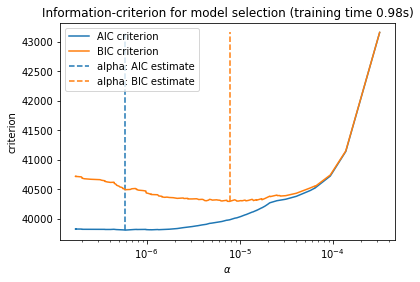

In [23]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)